# Muestreo de imagenes


# Setup

In [ ]:
%matplotlib inline

import random

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import cv2
from ultralytics import YOLO

# ======= CONFIG GENERAL =======
BASE = Path.home() / "ProyectoFinalVA"
SPLITS_DIR = BASE / "img_splits"         # train.txt, val.txt, test.txt con rutas a .npy
MODE1 = "HST"     
MODE2 =  "GST"                       # "HST" o "GST"
YOLO_IMAGES_DIR1 = BASE / f"YOLO/{MODE1}/images/train"  # carpeta de PNGs HST/GST
YOLO_IMAGES_DIR2 = BASE / f"YOLO/{MODE2}/images/train"
SEED = 0
random.seed(SEED)

# Tamaños y cantidad de muestras a mostrar
N_SPLIT = 1    # cuántas .npy mostrar (RGB/Térmica/Depth)
N_YOLO  = 3      # cuántas PNG HST/GST mostrar

# Paletas para las bandas
CMAP_THERM = 'inferno'
CMAP_DEPTH = 'viridis'


# Funciones

In [ ]:
def robust01(x, lo=1.0, hi=99.0):
    """Escala robusta por percentiles a rango [0, 1], ignorando inf/NaN si los hubiera."""
    x = x.astype(np.float32)
    finite = np.isfinite(x)
    if not finite.any():
        return np.zeros_like(x, dtype=np.float32)
    lo_v, hi_v = np.percentile(x[finite], [lo, hi])
    x = np.clip(x, lo_v, hi_v)
    return (x - lo_v) / (hi_v - lo_v + 1e-9)

def to_uint8_robust_rgb(rgb):
    """Normaliza por canal (1–99 pctl) y devuelve uint8."""
    rgb = rgb.astype(np.float32)
    p1  = np.percentile(rgb, 1, axis=(0,1))
    p99 = np.percentile(rgb, 99, axis=(0,1))
    out = (rgb - p1) / (p99 - p1 + 1e-9)
    out = np.clip(out, 0, 1)
    return (out * 255).astype(np.uint8)

def load_split_paths(split_txt: Path):
    with open(split_txt) as f:
        return [Path(l.strip()) for l in f if l.strip()]

def grid_shape(n, cols=3):
    rows = (n + cols - 1) // cols
    return rows, cols


# Visualizar NPY del split (RGB, Térmica, Profundidad)

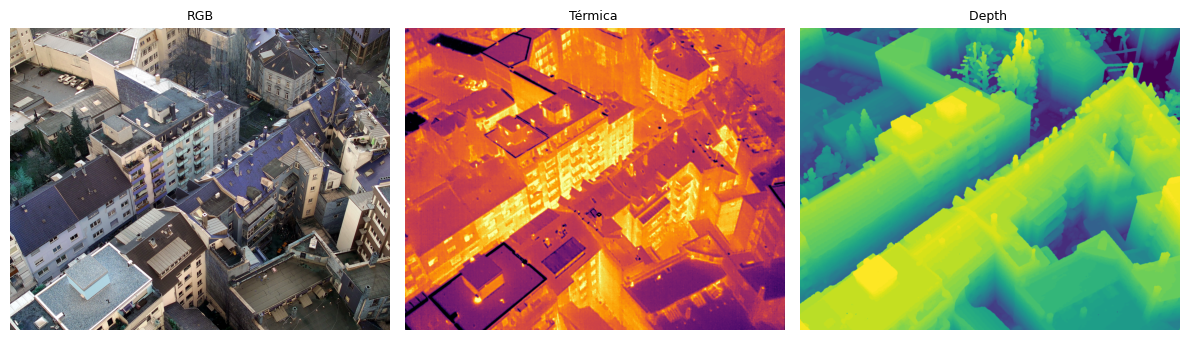

In [5]:

SPLIT = "train"  # "train" | "val" | "test"
split_txt = SPLITS_DIR / f"{SPLIT}.txt"
paths = load_split_paths(split_txt)
sample = random.sample(paths, min(N_SPLIT, len(paths)))

rows = len(sample)
fig, axes = plt.subplots(rows, 3, figsize=(12, max(2.8 * rows, 3.5)))
if rows == 1:
    axes = np.array([axes])

for i, p in enumerate(sample):
    arr = np.load(p)
    stem = p.stem

    # chequeo de forma
    if arr.ndim != 3 or arr.shape[-1] < 4:
        for j in range(3):
            axes[i, j].axis('off')
        axes[i, 0].set_title(f"{stem} (formato inesperado)")
        continue

    # --- RGB ---
    rgb = arr[..., :3]
    rgb_u8 = to_uint8_robust_rgb(rgb)
    axes[i, 0].imshow(rgb_u8)
    axes[i, 0].set_title("RGB", fontsize=9)
    axes[i, 0].axis('off')

    # --- Térmica (banda 3) ---
    therm = arr[..., 3]
    therm_n = robust01(therm)
    axes[i, 1].imshow(therm_n, cmap=CMAP_THERM)
    axes[i, 1].set_title("Térmica ", fontsize=9)
    axes[i, 1].axis('off')

    # --- Profundidad (banda 4, si existe) ---
    if arr.shape[-1] >= 5:
        depth = arr[..., 4]
        depth_n = robust01(depth)
        axes[i, 2].imshow(depth_n, cmap=CMAP_DEPTH)
        axes[i, 2].set_title("Depth ", fontsize=9)
    else:
        axes[i, 2].imshow(np.zeros_like(therm_n), cmap='gray')
        axes[i, 2].set_title("Depth: no disponible", fontsize=9)
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()


# Visualizar PNGs HST/GST 

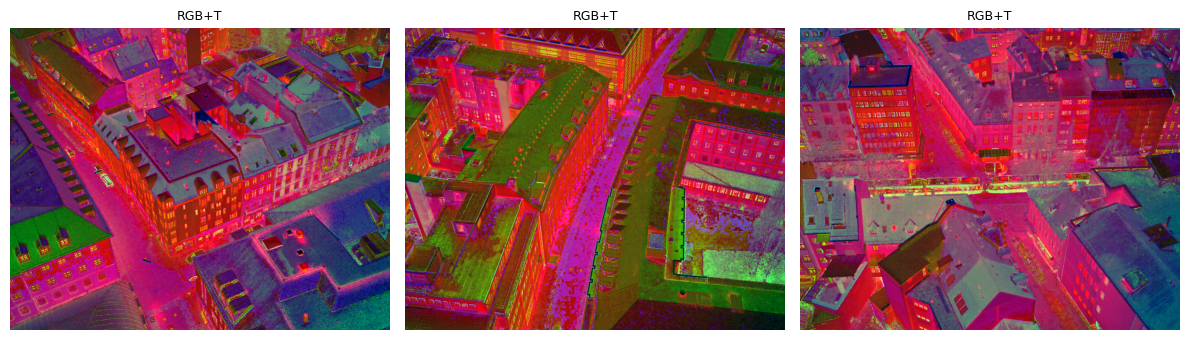

In [ ]:

imgs = list(YOLO_IMAGES_DIR1.glob("*.png"))
if len(imgs) == 0:
    print(f"No hay PNGs en {YOLO_IMAGES_DIR1}")
else:
    sample_png = random.sample(imgs, min(N_YOLO, len(imgs)))
    rows, cols = grid_shape(len(sample_png), cols=3)
    plt.figure(figsize=(12, max(3.5, rows * 3.5)))
    for i, img_path in enumerate(sample_png):
        img = cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.title("RGB+T", fontsize=9)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

imgs2 = list(YOLO_IMAGES_DIR2.glob("*.png"))
if len(imgs2) == 0:
    print(f"No hay PNGs en {YOLO_IMAGES_DIR2}")
else:
    sample_png = random.sample(imgs2, min(N_YOLO, len(imgs2)))
    rows, cols = grid_shape(len(sample_png), cols=3)
    plt.figure(figsize=(12, max(3.5, rows * 3.5)))
    for i, img_path in enumerate(sample_png):
        img = cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.title("RGB+T", fontsize=9)
        plt.axis("off")
    plt.tight_layout()
    plt.show()


# Entrenamiento HST

In [ ]:
yaml_path = Path("/home/ignacio/ProyectoFinalVA/YOLO/HST/YOLO.yaml")  # dataset completo
m = YOLO("yolo11x.pt")  

results = m.train(
    data=yaml_path,
    epochs=120,            # entrenamiento real (50–100 ideal)
    imgsz=640,            # resolución óptima para HST
    batch=16,             # con GPU L4 va bien, si se llena la VRAM baja a 12 u 8
    device=0,             # GPU
    workers=4,
    amp=True,             # mixed precision (reduce VRAM y acelera)
    project="/home/ignacio/ProyectoFinalVA/runs",
    name="yolo_hst",

    # 🔧 Estabilidad y augmentations
    rect=False,           # mejor para generalización
    cache="ram",          # acelera la segunda época en adelante
    patience=30,          # early stopping si no mejora
    hsv_h=0.0, hsv_s=0.2, hsv_v=0.2,  # leve jitter para HST
    mosaic=0.8, mixup=0.0,            # buen balance sin artefactos
    flipud=0.0, fliplr=0.5,           # solo flip horizontal
    degrees=0.0, shear=0.0, translate=0.1, scale=0.5, perspective=0.0,

    # ⚙️ Optimizador y scheduler
    optimizer="auto",     
    cos_lr=True,          
)

print(results)


100%|██████████| 49.0M/49.0M [00:00<00:00, 346MB/s]


New https://pypi.org/project/ultralytics/8.3.228 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.2 🚀 Python-3.10.17 torch-2.9.1+cu128 CUDA:0 (NVIDIA L4, 22478MiB)
engine/trainer: task=detect, mode=train, model=yolo11l.pt, data=/home/ignacio/ProyectoFinalVA/YOLO/HST/YOLO.yaml, epochs=100, time=None, patience=30, batch=16, imgsz=640, save=True, save_period=-1, cache=ram, device=0, workers=4, project=/home/ignacio/ProyectoFinalVA/runs, name=yolo_hst, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina

100%|██████████| 5.35M/5.35M [00:00<00:00, 126MB/s]


AMP: checks passed ✅


train: Scanning /home/ignacio/ProyectoFinalVA/YOLO/HST/labels/train.cache... 325 images, 74 backgrounds, 0 corrupt: 100%|██████████| 399/399 [00:00<?, ?it/s]

train: WARNING ⚠️ /home/ignacio/ProyectoFinalVA/YOLO/HST/images/train/DJI_0997_R.png: 10 duplicate labels removed


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


train: Caching images (0.4GB RAM): 100%|██████████| 399/399 [00:39<00:00, 10.13it/s]
val: Scanning /home/ignacio/ProyectoFinalVA/YOLO/HST/labels/val.cache... 111 images, 23 backgrounds, 0 corrupt: 100%|██████████| 134/134 [00:00<?, ?it/s]

val: WARNING ⚠️ /home/ignacio/ProyectoFinalVA/YOLO/HST/images/val/DJI_0995_R.png: 10 duplicate labels removed


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


val: Caching images (0.1GB RAM): 100%|██████████| 134/134 [00:12<00:00, 10.54it/s]


Plotting labels to /home/ignacio/ProyectoFinalVA/runs/yolo_hst/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 167 weight(decay=0.0), 174 weight(decay=0.0005), 173 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to /home/ignacio/ProyectoFinalVA/runs/yolo_hst
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      11.1G      3.539      3.828      2.445        118        640: 100%|██████████| 25/25 [00:29<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:06<00:00,  1.29s/it]

                   all        134        810     0.0164     0.0691    0.00675    0.00202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      11.3G      2.932      3.047      2.095        116        640: 100%|██████████| 25/25 [00:11<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.48it/s]

                   all        134        810     0.0164     0.0691    0.00675    0.00202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      11.3G      2.867      2.741      2.046        193        640: 100%|██████████| 25/25 [00:11<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.68it/s]

                   all        134        810   0.000158    0.00494   7.23e-05   2.17e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      11.3G      2.747      2.525      1.976        149        640: 100%|██████████| 25/25 [00:11<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.44it/s]

                   all        134        810   0.000544      0.021   0.000257   8.44e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      11.3G      2.741        2.6      1.979        133        640: 100%|██████████| 25/25 [00:10<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.39it/s]

                   all        134        810   3.09e-05    0.00123   1.62e-05   3.24e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      11.4G       2.71      2.554      1.906        145        640: 100%|██████████| 25/25 [00:11<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.23it/s]

                   all        134        810   3.09e-05    0.00123   1.62e-05   3.24e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      11.3G      2.533      2.356      1.854         95        640: 100%|██████████| 25/25 [00:11<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.28it/s]

                   all        134        810     0.0112     0.0914    0.00466    0.00148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      11.4G      2.438      2.195      1.734        121        640: 100%|██████████| 25/25 [00:11<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.24it/s]

                   all        134        810     0.0803     0.0852       0.03     0.0116



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      11.3G       2.38      2.133      1.737        127        640: 100%|██████████| 25/25 [00:11<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.50it/s]

                   all        134        810     0.0641      0.084     0.0146    0.00439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      11.3G      2.253      1.964      1.651        123        640: 100%|██████████| 25/25 [00:11<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.46it/s]

                   all        134        810      0.189      0.122     0.0764     0.0263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      11.4G      2.321      1.991      1.702        102        640: 100%|██████████| 25/25 [00:11<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.41it/s]

                   all        134        810      0.132      0.101     0.0498     0.0164



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      11.4G      2.275      2.009      1.654        143        640: 100%|██████████| 25/25 [00:11<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.66it/s]

                   all        134        810      0.204      0.119     0.0817     0.0322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      11.3G      2.211      1.943      1.636        136        640: 100%|██████████| 25/25 [00:10<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.48it/s]

                   all        134        810      0.256      0.128     0.0959      0.037



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      11.3G       2.14      1.893      1.614        112        640: 100%|██████████| 25/25 [00:10<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.47it/s]

                   all        134        810      0.283      0.168      0.118     0.0476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      11.3G      2.106      1.801      1.571        132        640: 100%|██████████| 25/25 [00:11<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.42it/s]

                   all        134        810      0.227      0.107     0.0763     0.0307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      11.4G      2.119      1.771      1.539        153        640: 100%|██████████| 25/25 [00:11<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.60it/s]

                   all        134        810      0.254      0.184      0.126     0.0486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      11.3G      1.973      1.661      1.472        128        640: 100%|██████████| 25/25 [00:11<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.56it/s]

                   all        134        810      0.342      0.186      0.148     0.0648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      11.4G      1.986      1.666      1.473        113        640: 100%|██████████| 25/25 [00:11<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.56it/s]

                   all        134        810      0.307      0.158      0.126     0.0539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      11.4G      1.932      1.603      1.454        158        640: 100%|██████████| 25/25 [00:11<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.48it/s]

                   all        134        810      0.392      0.206      0.168      0.073



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      11.4G      1.937      1.621      1.457         96        640: 100%|██████████| 25/25 [00:11<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.57it/s]

                   all        134        810      0.344      0.205      0.167     0.0785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      11.3G      1.991      1.687      1.504        160        640: 100%|██████████| 25/25 [00:10<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.64it/s]

                   all        134        810      0.455      0.233       0.22     0.0973



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      11.4G      1.877       1.55      1.442        125        640: 100%|██████████| 25/25 [00:11<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.52it/s]

                   all        134        810      0.408      0.185      0.168     0.0729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      11.4G      1.829      1.482      1.384        111        640: 100%|██████████| 25/25 [00:10<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.67it/s]

                   all        134        810      0.502      0.209      0.212     0.0929



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      11.3G      1.758      1.408      1.338        129        640: 100%|██████████| 25/25 [00:11<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.59it/s]

                   all        134        810      0.509      0.211       0.21     0.0959



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      11.3G      1.795       1.42      1.375        147        640: 100%|██████████| 25/25 [00:11<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.68it/s]

                   all        134        810      0.522      0.228      0.217     0.0902



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      11.4G      1.802      1.389      1.358         85        640: 100%|██████████| 25/25 [00:11<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.59it/s]

                   all        134        810       0.44      0.226      0.208     0.0798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      11.4G      1.778      1.442      1.375        110        640: 100%|██████████| 25/25 [00:11<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.60it/s]

                   all        134        810      0.438      0.225      0.214      0.104



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      11.4G      1.841      1.484      1.398         91        640: 100%|██████████| 25/25 [00:11<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.67it/s]

                   all        134        810      0.476      0.248      0.242      0.115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      11.3G      1.727       1.36      1.338        150        640: 100%|██████████| 25/25 [00:11<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.68it/s]

                   all        134        810      0.492      0.246      0.232      0.116



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      11.3G      1.734      1.362      1.356        139        640: 100%|██████████| 25/25 [00:11<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.65it/s]

                   all        134        810      0.479      0.242      0.234       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      11.4G      1.691      1.322      1.321        142        640: 100%|██████████| 25/25 [00:11<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.67it/s]

                   all        134        810      0.541      0.236      0.232      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      11.4G      1.613      1.237      1.268        144        640: 100%|██████████| 25/25 [00:11<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.73it/s]

                   all        134        810      0.575      0.265      0.277      0.139



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      11.3G      1.636      1.262      1.324        117        640: 100%|██████████| 25/25 [00:11<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.71it/s]

                   all        134        810      0.625      0.268      0.292      0.141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      11.4G      1.605        1.2      1.275        101        640: 100%|██████████| 25/25 [00:10<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.61it/s]

                   all        134        810      0.535      0.277      0.277      0.134



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      11.4G      1.604      1.216      1.287        128        640: 100%|██████████| 25/25 [00:11<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.69it/s]

                   all        134        810      0.603      0.296      0.307      0.164



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      11.4G      1.633      1.229      1.281        112        640: 100%|██████████| 25/25 [00:11<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.72it/s]

                   all        134        810       0.64      0.311      0.324      0.171



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      11.3G      1.578      1.186      1.246        119        640: 100%|██████████| 25/25 [00:11<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.65it/s]

                   all        134        810      0.608      0.247      0.251       0.12



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      11.4G      1.555      1.189      1.244        132        640: 100%|██████████| 25/25 [00:11<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.68it/s]

                   all        134        810      0.545      0.267      0.257       0.12



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      11.4G      1.569      1.179      1.261        137        640: 100%|██████████| 25/25 [00:11<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.75it/s]

                   all        134        810      0.649        0.3      0.318      0.159



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      11.3G      1.496       1.12      1.238        157        640: 100%|██████████| 25/25 [00:11<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.64it/s]

                   all        134        810      0.676      0.231       0.26      0.118



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      11.3G      1.512      1.147      1.214        119        640: 100%|██████████| 25/25 [00:10<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.69it/s]

                   all        134        810      0.584      0.305      0.303      0.155



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      11.4G      1.538      1.161       1.26        119        640: 100%|██████████| 25/25 [00:10<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.72it/s]

                   all        134        810      0.586      0.305      0.307      0.149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      11.3G      1.518      1.103      1.241        142        640: 100%|██████████| 25/25 [00:11<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.70it/s]

                   all        134        810      0.587      0.298        0.3      0.149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      11.4G      1.541      1.119      1.225        114        640: 100%|██████████| 25/25 [00:11<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.68it/s]

                   all        134        810      0.588      0.349      0.341      0.187



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      11.3G      1.549      1.133      1.212        143        640: 100%|██████████| 25/25 [00:11<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.67it/s]

                   all        134        810      0.665      0.321      0.349      0.185



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      11.4G      1.394      1.019      1.161        151        640: 100%|██████████| 25/25 [00:11<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.68it/s]

                   all        134        810      0.629      0.327      0.323      0.166



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      11.3G      1.395      1.009      1.167         96        640: 100%|██████████| 25/25 [00:11<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.74it/s]

                   all        134        810      0.649      0.299      0.314      0.151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      11.4G      1.421      1.047      1.178        157        640: 100%|██████████| 25/25 [00:11<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.69it/s]

                   all        134        810      0.597      0.294      0.311      0.139



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      11.3G      1.402      1.041      1.171        149        640: 100%|██████████| 25/25 [00:10<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.67it/s]

                   all        134        810       0.65      0.344       0.34      0.166



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      11.4G       1.39      1.029      1.174        110        640: 100%|██████████| 25/25 [00:11<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.73it/s]

                   all        134        810       0.63      0.318      0.334      0.177



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      11.3G      1.382      1.021      1.166         93        640: 100%|██████████| 25/25 [00:11<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.65it/s]

                   all        134        810      0.636      0.333      0.351      0.188



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      11.3G      1.374      1.009      1.173        109        640: 100%|██████████| 25/25 [00:11<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.50it/s]

                   all        134        810      0.688      0.304      0.343      0.175



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      11.3G      1.332     0.9872      1.166        102        640: 100%|██████████| 25/25 [00:11<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.69it/s]

                   all        134        810      0.703      0.321      0.357      0.194



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      11.4G      1.352      1.025      1.166         95        640: 100%|██████████| 25/25 [00:10<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.70it/s]

                   all        134        810      0.658      0.312      0.339      0.175



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      11.4G      1.319     0.9613      1.136        114        640: 100%|██████████| 25/25 [00:10<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.72it/s]

                   all        134        810       0.71      0.316      0.348      0.189



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      11.4G      1.352     0.9816      1.147        103        640: 100%|██████████| 25/25 [00:11<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.68it/s]

                   all        134        810      0.708      0.346      0.369      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      11.3G       1.34     0.9484      1.139        149        640: 100%|██████████| 25/25 [00:11<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.69it/s]

                   all        134        810      0.621       0.37      0.382      0.211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      11.4G      1.273     0.9125      1.117         85        640: 100%|██████████| 25/25 [00:11<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.64it/s]

                   all        134        810       0.68      0.333      0.355      0.185



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      11.4G      1.262     0.9039      1.124        100        640: 100%|██████████| 25/25 [00:11<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.74it/s]

                   all        134        810      0.652      0.323      0.346      0.174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      11.3G      1.267      0.912      1.109        176        640: 100%|██████████| 25/25 [00:11<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.73it/s]

                   all        134        810      0.613       0.32      0.335      0.173



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      11.3G      1.269     0.9223       1.12        123        640: 100%|██████████| 25/25 [00:11<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.61it/s]

                   all        134        810      0.672      0.341      0.361       0.19



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      11.3G      1.213     0.8552      1.111        124        640: 100%|██████████| 25/25 [00:11<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.69it/s]

                   all        134        810      0.704      0.344      0.373      0.209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      11.4G      1.251     0.8871      1.111        124        640: 100%|██████████| 25/25 [00:11<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.73it/s]

                   all        134        810      0.672      0.341      0.356      0.176



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      11.4G      1.199     0.8747      1.081        127        640: 100%|██████████| 25/25 [00:11<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.70it/s]

                   all        134        810      0.695      0.363      0.386      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      11.3G      1.209     0.8579      1.089         92        640: 100%|██████████| 25/25 [00:11<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.69it/s]

                   all        134        810      0.679      0.391      0.405      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      11.3G      1.172     0.8385      1.075         97        640: 100%|██████████| 25/25 [00:11<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.66it/s]

                   all        134        810      0.686       0.37      0.393      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      11.3G      1.184      0.836      1.071        112        640: 100%|██████████| 25/25 [00:11<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.68it/s]

                   all        134        810      0.699      0.375      0.401      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      11.4G      1.184     0.8486      1.086        108        640: 100%|██████████| 25/25 [00:11<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.75it/s]

                   all        134        810      0.669      0.374      0.394      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      11.3G       1.16     0.8205      1.058        144        640: 100%|██████████| 25/25 [00:11<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.69it/s]

                   all        134        810      0.748      0.364      0.388      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      11.4G      1.153     0.8142      1.078        109        640: 100%|██████████| 25/25 [00:10<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.74it/s]

                   all        134        810      0.635      0.368      0.373      0.183



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      11.4G      1.171     0.8146      1.063        169        640: 100%|██████████| 25/25 [00:11<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.74it/s]

                   all        134        810      0.698      0.366      0.384      0.198



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      11.4G      1.136     0.7872       1.05        142        640: 100%|██████████| 25/25 [00:11<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.75it/s]

                   all        134        810      0.751      0.384      0.417      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      11.3G      1.134     0.7866      1.038        128        640: 100%|██████████| 25/25 [00:11<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.70it/s]

                   all        134        810      0.705      0.396      0.417      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      11.4G       1.14     0.7965      1.058        149        640: 100%|██████████| 25/25 [00:11<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.70it/s]

                   all        134        810       0.72      0.375      0.402      0.218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      11.4G      1.071     0.7465      1.019        161        640: 100%|██████████| 25/25 [00:10<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.71it/s]

                   all        134        810      0.678      0.394      0.409      0.227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      11.4G      1.107      0.799      1.059        123        640: 100%|██████████| 25/25 [00:11<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.76it/s]

                   all        134        810      0.697       0.39      0.415       0.23



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      11.3G      1.077      0.755       1.02        147        640: 100%|██████████| 25/25 [00:10<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.73it/s]

                   all        134        810      0.721      0.393      0.414      0.225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      11.3G      1.074     0.7578      1.027        107        640: 100%|██████████| 25/25 [00:10<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.70it/s]

                   all        134        810      0.678      0.389      0.405       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      11.4G      1.064     0.7372      1.022        115        640: 100%|██████████| 25/25 [00:11<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.58it/s]

                   all        134        810      0.652      0.386      0.403      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      11.3G      1.015     0.7235      1.021         87        640: 100%|██████████| 25/25 [00:11<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.79it/s]

                   all        134        810      0.693      0.383      0.415      0.225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      11.3G      1.025      0.728      1.021        131        640: 100%|██████████| 25/25 [00:10<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.62it/s]

                   all        134        810      0.692       0.39      0.422      0.236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      11.4G      1.008     0.7204      1.011        150        640: 100%|██████████| 25/25 [00:10<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.66it/s]

                   all        134        810      0.674      0.388      0.411      0.225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      11.4G      1.023     0.7161      1.014        136        640: 100%|██████████| 25/25 [00:10<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.64it/s]

                   all        134        810      0.703      0.377      0.411      0.235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      11.4G      1.011     0.7127      1.009        120        640: 100%|██████████| 25/25 [00:11<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.74it/s]

                   all        134        810      0.718      0.368      0.408      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      11.3G      1.049     0.7508      1.039        123        640: 100%|██████████| 25/25 [00:10<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.79it/s]

                   all        134        810      0.679       0.38      0.407      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      11.4G      1.042     0.7366      1.019        150        640: 100%|██████████| 25/25 [00:10<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.78it/s]

                   all        134        810      0.679      0.379      0.411      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      11.4G      1.005     0.7299      1.015         87        640: 100%|██████████| 25/25 [00:10<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.66it/s]

                   all        134        810      0.682      0.389      0.414      0.231



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      11.4G     0.9831     0.7007      1.001        121        640: 100%|██████████| 25/25 [00:11<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.80it/s]

                   all        134        810      0.697      0.385      0.415      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      11.3G     0.9958     0.7188      1.019        108        640: 100%|██████████| 25/25 [00:10<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.76it/s]

                   all        134        810      0.687      0.388      0.418      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      11.4G     0.9856     0.7071      1.011        155        640: 100%|██████████| 25/25 [00:10<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.77it/s]

                   all        134        810      0.733      0.375      0.425      0.242


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      11.3G      1.316     0.9888      1.204        121        640: 100%|██████████| 25/25 [00:11<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.70it/s]

                   all        134        810      0.725      0.374      0.417      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      11.4G      1.275     0.9541      1.187         52        640: 100%|██████████| 25/25 [00:11<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.68it/s]

                   all        134        810       0.73      0.374       0.41      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      11.3G      1.257     0.9397      1.204         92        640: 100%|██████████| 25/25 [00:10<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.71it/s]

                   all        134        810      0.665      0.395      0.413       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      11.3G      1.235      0.923      1.178         91        640: 100%|██████████| 25/25 [00:10<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.76it/s]

                   all        134        810      0.699      0.398      0.418      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      11.4G      1.219      0.931      1.184         89        640: 100%|██████████| 25/25 [00:10<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.73it/s]

                   all        134        810      0.711      0.398      0.423      0.229



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      11.4G      1.217     0.9266      1.172        106        640: 100%|██████████| 25/25 [00:11<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.74it/s]

                   all        134        810      0.697        0.4      0.425      0.229



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      11.3G      1.201     0.8899      1.138         81        640: 100%|██████████| 25/25 [00:10<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.77it/s]

                   all        134        810      0.709      0.404      0.431      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      11.4G      1.207     0.9037      1.151         68        640: 100%|██████████| 25/25 [00:10<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.54it/s]

                   all        134        810      0.729       0.39      0.427      0.228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      11.4G       1.19      0.909      1.154         95        640: 100%|██████████| 25/25 [00:10<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.75it/s]

                   all        134        810      0.729      0.393      0.427      0.223



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      11.4G      1.206     0.8959      1.151         88        640: 100%|██████████| 25/25 [00:11<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.63it/s]

                   all        134        810      0.724      0.391       0.43      0.228



100 epochs completed in 0.408 hours.
Optimizer stripped from /home/ignacio/ProyectoFinalVA/runs/yolo_hst/weights/last.pt, 51.2MB
Optimizer stripped from /home/ignacio/ProyectoFinalVA/runs/yolo_hst/weights/best.pt, 51.2MB

Validating /home/ignacio/ProyectoFinalVA/runs/yolo_hst/weights/best.pt...
Ultralytics 8.3.2 🚀 Python-3.10.17 torch-2.9.1+cu128 CUDA:0 (NVIDIA L4, 22478MiB)
YOLO11l summary (fused): 464 layers, 25,280,083 parameters, 0 gradients, 86.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.34it/s]


                   all        134        810      0.733      0.376      0.425      0.242
Speed: 0.1ms preprocess, 6.5ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to /home/ignacio/ProyectoFinalVA/runs/yolo_hst
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f88eeb29480>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.0310

# Predicciones HST

In [8]:
trained = YOLO("/home/ignacio/ProyectoFinalVA/runs/yolo_hst/weights/best.pt")

metrics = trained.val()
print(metrics)  

trained.predict(
    source="/home/ignacio/ProyectoFinalVA/YOLO/HST/images/test",
    imgsz=416,
    conf=0.25,
    save=True,
    project="/home/ignacio/ProyectoFinalVA/runs",
    name="yolo_hst_pred"
)


Ultralytics 8.3.2 🚀 Python-3.10.17 torch-2.9.1+cu128 CUDA:0 (NVIDIA L4, 22478MiB)
YOLO11l summary (fused): 464 layers, 25,280,083 parameters, 0 gradients, 86.6 GFLOPs


val: Scanning /home/ignacio/ProyectoFinalVA/YOLO/HST/labels/val.cache... 111 images, 23 backgrounds, 0 corrupt: 100%|██████████| 134/134 [00:00<?, ?it/s]

val: WARNING ⚠️ /home/ignacio/ProyectoFinalVA/YOLO/HST/images/val/DJI_0995_R.png: 10 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:15<00:00,  1.67s/it]


                   all        134        810       0.73      0.375      0.426      0.242
Speed: 0.2ms preprocess, 13.7ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to runs/detect/val
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f88d454a350>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.03303

image 22/69 /home/ignacio/ProyectoFinalVA/YOLO/HST/images/test/DJI_0301_R.png: 352x416 13 Fuga Térmicas, 19.6ms
image 23/69 /home/ignacio/ProyectoFinalVA/YOLO/HST/images/test/DJI_0309_R.png: 352x416 10 Fuga Térmicas, 48.5ms
image 24/69 /home/ignacio/ProyectoFinalVA/YOLO/HST/images/test/DJI_0339_R.png: 352x416 5 Fuga Térmicas, 19.1ms
image 25/69 /home/ignacio/ProyectoFinalVA/YOLO/HST/images/test/DJI_0345_R.png: 352x416 3 Fuga Térmicas, 19.3ms
image 26/69 /home/ignacio/ProyectoFinalVA/YOLO/HST/images/test/DJI_0351_R.png: 352x416 2 Fuga Térmicas, 19.4ms
image 27/69 /home/ignacio/ProyectoFinalVA/YOLO/HST/images/test/DJI_0363_R.png: 352x416 1 Fuga Térmica, 21.7ms
image 28/69 /home/ignacio/ProyectoFinalVA/YOLO/HST/images/test/DJI_0369_R.png: 352x416 1 Fuga Térmica, 20.3ms
image 29/69 /home/ignacio/ProyectoFinalVA/YOLO/HST/images/test/DJI_0379_R.png: 352x416 (no detections), 20.7ms
image 30/69 /home/ignacio/ProyectoFinalVA/YOLO/HST/images/test/DJI_0383_R.png: 352x416 (no detections), 19.4ms
i

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'Fuga Térmica'}
 obb: None
 orig_img: array([[[120,   7,   0],
         [120,   7,   0],
         [120,   7,   0],
         ...,
         [ 36, 112,   1],
         [ 33, 101,   3],
         [ 32,  77,   3]],
 
        [[113,   7,  27],
         [113,   7,  27],
         [120,   8,  27],
         ...,
         [ 36,  77,   3],
         [ 34,  64,   5],
         [ 34,  51,   5]],
 
        [[100,   6,  27],
         [100,   6,  28],
         [113,   9,  27],
         ...,
         [ 38,  59,   5],
         [ 37,  45,   5],
         [ 34,  41,   3]],
 
        ...,
 
        [[ 34,  68,  21],
         [ 30,  66,  23],
         [ 30,  74,  25],
         ...,
         [ 27,  62,   0],
         [ 23,  66,   0],
         [ 23,  66,   0]],
 
        [[ 30,  64,  21],
         [ 34,  94,  21],
         [ 30,  90,  23],
         ...,
         [ 2

# Predicciones HST

Ultralytics 8.3.2 🚀 Python-3.10.17 torch-2.9.1+cu128 CUDA:0 (NVIDIA L4, 22478MiB)
YOLO11l summary (fused): 464 layers, 25,280,083 parameters, 0 gradients, 86.6 GFLOPs


val: Scanning /home/ignacio/ProyectoFinalVA/YOLO/HST/labels/val.cache... 111 images, 23 backgrounds, 0 corrupt: 100%|██████████| 134/134 [00:00<?, ?it/s]

val: WARNING ⚠️ /home/ignacio/ProyectoFinalVA/YOLO/HST/images/val/DJI_0995_R.png: 10 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:13<00:00,  1.53s/it]


                   all        134        810       0.73      0.375      0.426      0.242
Speed: 0.3ms preprocess, 12.4ms inference, 0.0ms loss, 3.2ms postprocess per image
Results saved to runs/detect/val2
===== MÉTRICAS GLOBALES (VAL) =====
Precision   (mp)      : 0.730
Recall      (mr)      : 0.375
mAP@0.5     (map50)   : 0.426
mAP@0.5:0.95 (map)    : 0.242


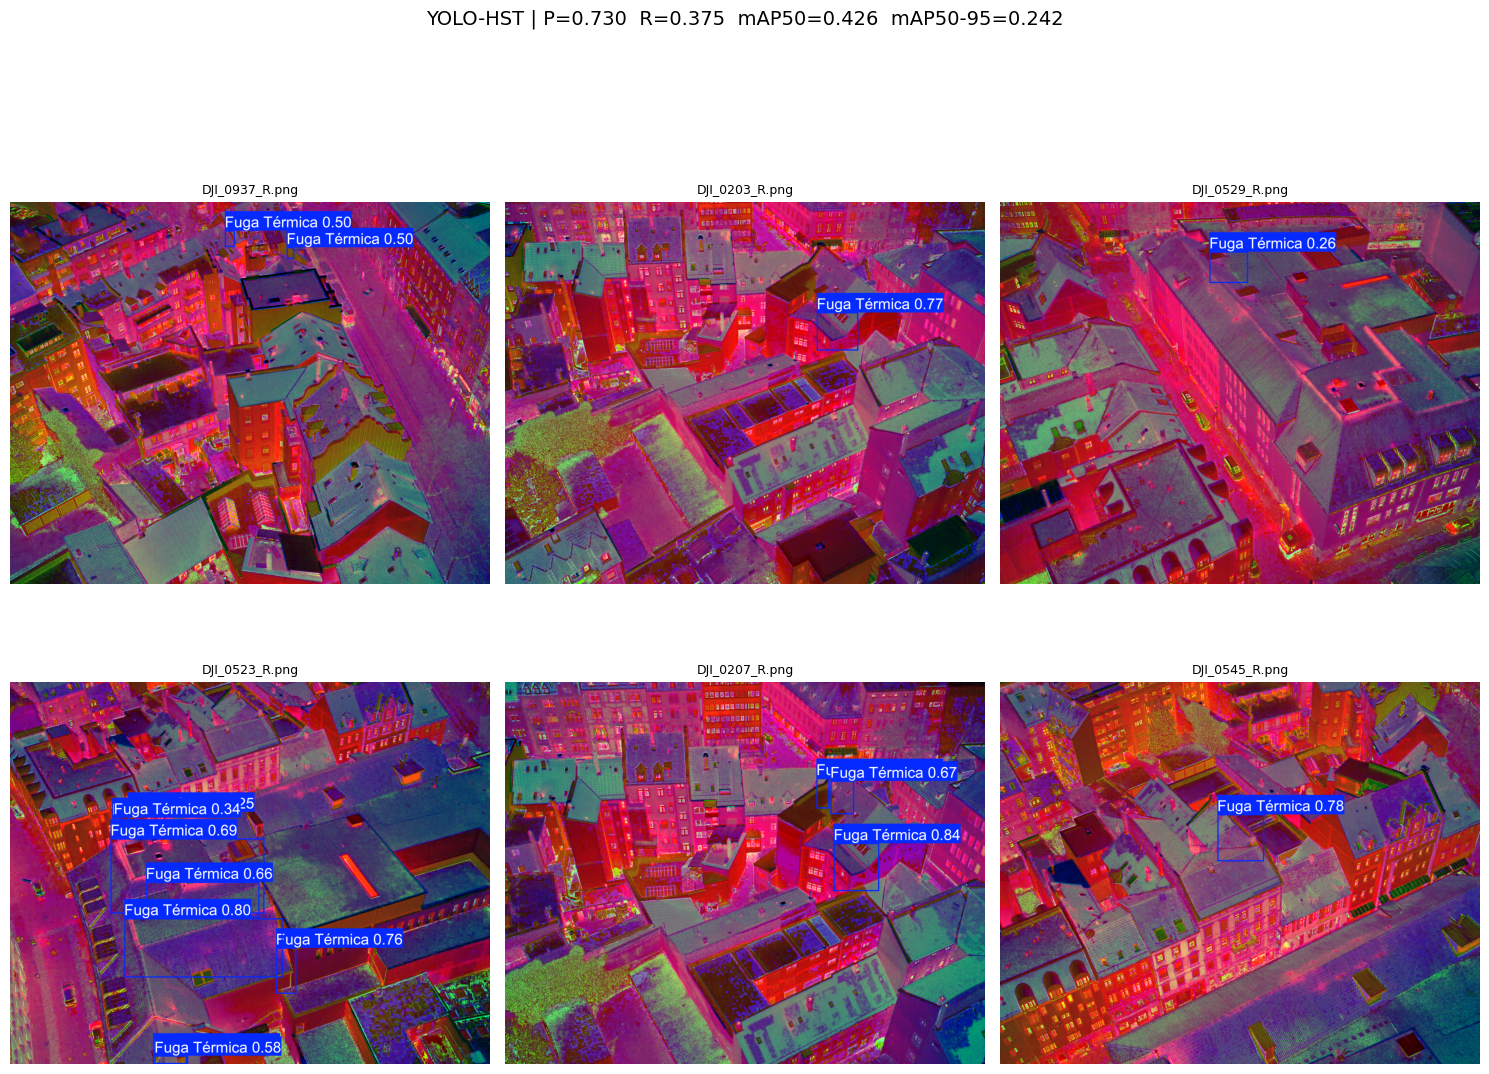

(-0.5, 2399.5, 1199.5, -0.5)

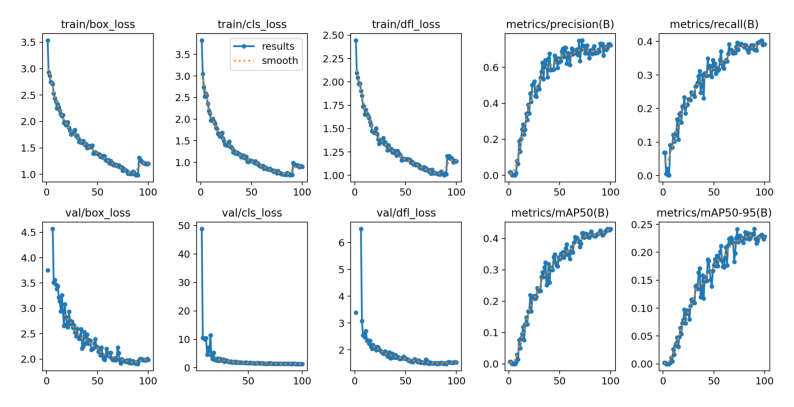

In [ ]:


# ========= CONFIG =========
RUN_NAME   = "yolo_hst"  # el mismo 'name=' que usaste en el train
RUNS_DIR   = Path("/home/ignacio/ProyectoFinalVA/runs")
BEST_WEIGHTS = RUNS_DIR / RUN_NAME / "weights" / "best.pt"
IMG_PATH = Path("/home/ignacio/ProyectoFinalVA/runs/yolo_hst/results.png")

DATA_YAML = Path("/home/ignacio/ProyectoFinalVA/YOLO/HST/YOLO.yaml")
DATA_ROOT = Path("/home/ignacio/ProyectoFinalVA/YOLO/HST")
TEST_DIR  = DATA_ROOT / "images" / "test"

N_IMGS = 6
IMGSZ  = 640
CONF   = 0.25

model = YOLO(str(BEST_WEIGHTS))

# --------- 1) Métricas globales en val ---------
metrics = model.val(data=str(DATA_YAML))   # asegura usar tu YAML

mp    = metrics.box.mp
mr    = metrics.box.mr
map50 = metrics.box.map50
map95 = metrics.box.map

print("===== MÉTRICAS GLOBALES (VAL) =====")
print(f"Precision   (mp)      : {mp:.3f}")
print(f"Recall      (mr)      : {mr:.3f}")
print(f"mAP@0.5     (map50)   : {map50:.3f}")
print(f"mAP@0.5:0.95 (map)    : {map95:.3f}")
print("====================================")

# --------- 2) Predicciones sobre algunas imágenes de test ---------
test_paths = sorted(TEST_DIR.glob("*.png"))
if not test_paths:
    raise RuntimeError(f"No encontré PNGs en {TEST_DIR}")

sample = random.sample(test_paths, min(N_IMGS, len(test_paths)))

results = model.predict(
    source=[str(p) for p in sample],
    imgsz=IMGSZ,
    conf=CONF,
    save=False,
    verbose=False
)

cols = 3
rows = (len(results) + cols - 1) // cols
plt.figure(figsize=(5 * cols, 5 * rows + 2))

# Texto con métricas globales (arriba de todo)
plt.suptitle(
    f"YOLO-HST | P={mp:.3f}  R={mr:.3f}  mAP50={map50:.3f}  mAP50-95={map95:.3f}",
    fontsize=14, y=0.98
)

for i, (p, r) in enumerate(zip(sample, results), start=1):
    plotted = r.plot()         # BGR
    plotted = plotted[..., ::-1]  # a RGB
    ax = plt.subplot(rows, cols, i)
    ax.imshow(plotted)
    ax.set_title(
        '', fontsize=9)
    ax.axis("off")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
plt.figure(figsize=(10,6))
plt.imshow(plt.imread(IMG_PATH)); plt.axis("off")



# Entrenamiento GST

In [4]:
yaml_path = Path("/home/ignacio/ProyectoFinalVA/YOLO/GST/YOLO_gst.yaml")  # dataset completo
m = YOLO("yolo11l.pt")  

results = m.train(
    data=yaml_path,
    epochs=100,            # entrenamiento real (50–100 ideal)
    imgsz=640,            # resolución óptima para GST
    batch=8,             # con GPU L4 va bien, si se llena la VRAM baja a 12 u 8
    device=0,             # GPU
    workers=4,
    amp=True,             # mixed precision (reduce VRAM y acelera)
    project="/home/ignacio/ProyectoFinalVA/runs",
    name="yolo_gst",

    # 🔧 Estabilidad y augmentations
    rect=False,           # mejor para generalización
    cache="disk",          # acelera la segunda época en adelante
    patience=30,          # early stopping si no mejora
    hsv_h=0.0, hsv_s=0.2, hsv_v=0.2,  # leve jitter para GST
    mosaic=0.8, mixup=0.0,            # buen balance sin artefactos
    flipud=0.0, fliplr=0.5,           # solo flip horizontal
    degrees=0.0, shear=0.0, translate=0.1, scale=0.5, perspective=0.0,

    # ⚙️ Optimizador y scheduler
    optimizer="auto",     
    cos_lr=True,          
)

print(results)

New https://pypi.org/project/ultralytics/8.3.228 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.2 🚀 Python-3.10.17 torch-2.9.1+cu128 CUDA:0 (NVIDIA L4, 22478MiB)
engine/trainer: task=detect, mode=train, model=yolo11l.pt, data=/home/ignacio/ProyectoFinalVA/YOLO/GST/YOLO_gst.yaml, epochs=100, time=None, patience=30, batch=8, imgsz=640, save=True, save_period=-1, cache=disk, device=0, workers=4, project=/home/ignacio/ProyectoFinalVA/runs, name=yolo_gst5, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, r

train: Scanning /home/ignacio/ProyectoFinalVA/YOLO/GST/labels/train.cache... 325 images, 74 backgrounds, 0 corrupt: 100%|██████████| 399/399 [00:00<?, ?it/s]

train: WARNING ⚠️ /home/ignacio/ProyectoFinalVA/YOLO/GST/images/train/DJI_0997_R.png: 10 duplicate labels removed



train: Caching images (10.1GB Disk): 100%|██████████| 399/399 [00:00<00:00, 44629.77it/s]
val: Scanning /home/ignacio/ProyectoFinalVA/YOLO/GST/labels/val.cache... 111 images, 23 backgrounds, 0 corrupt: 100%|██████████| 134/134 [00:00<?, ?it/s]

val: WARNING ⚠️ /home/ignacio/ProyectoFinalVA/YOLO/GST/images/val/DJI_0995_R.png: 10 duplicate labels removed



val: Caching images (3.2GB Disk): 100%|██████████| 134/134 [00:13<00:00, 10.25it/s]


Plotting labels to /home/ignacio/ProyectoFinalVA/runs/yolo_gst5/labels.jpg... 
val: WARNING ⚠️ Removing corrupt *.npy image file /home/ignacio/ProyectoFinalVA/YOLO/GST/images/val/DJI_0665_R.npy due to: cannot reshape array of size 0 into shape (2680,3370,3)
val: WARNING ⚠️ Removing corrupt *.npy image file /home/ignacio/ProyectoFinalVA/YOLO/GST/images/val/DJI_0683_R.npy due to: cannot reshape array of size 0 into shape (2680,3370,3)
val: WARNING ⚠️ Removing corrupt *.npy image file /home/ignacio/ProyectoFinalVA/YOLO/GST/images/val/DJI_0687_R.npy due to: cannot reshape array of size 0 into shape (2680,3370,3)
val: WARNING ⚠️ Removing corrupt *.npy image file /home/ignacio/ProyectoFinalVA/YOLO/GST/images/val/DJI_0689_R.npy due to: No data left in file
val: WARNING ⚠️ Removing corrupt *.npy image file /home/ignacio/ProyectoFinalVA/YOLO/GST/images/val/DJI_0691_R.npy due to: No data left in file
val: WARNING ⚠️ Removing corrupt *.npy image file /home/ignacio/ProyectoFinalVA/YOLO/GST/images/

      1/100      6.42G      3.538      3.793      2.537         50        640: 100%|██████████| 50/50 [01:07<00:00,  1.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.35it/s]

                   all        134        810   0.000994     0.0123   0.000366   9.93e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      6.08G      3.396      3.416      2.435         40        640: 100%|██████████| 50/50 [00:58<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.28it/s]

                   all        134        810   0.000327    0.00494   0.000143   4.98e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      6.09G       3.35      3.342      2.443         41        640: 100%|██████████| 50/50 [01:01<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.90it/s]

                   all        134        810   0.000736     0.0037   0.000359   0.000144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      6.11G      3.254      3.206      2.352         46        640: 100%|██████████| 50/50 [00:58<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  2.20it/s]

                   all        134        810   0.000736     0.0037   0.000359   0.000144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      6.12G      3.174      3.167       2.31         68        640: 100%|██████████| 50/50 [00:58<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.57it/s]

                   all        134        810     0.0292     0.0531    0.00882     0.0028



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      6.13G      3.112      3.035      2.265         41        640: 100%|██████████| 50/50 [00:58<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.51it/s]

                   all        134        810     0.0477     0.0642     0.0136    0.00404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      6.13G      3.091      3.092      2.217         36        640: 100%|██████████| 50/50 [00:58<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.48it/s]

                   all        134        810     0.0488     0.0494    0.00848     0.0024



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100       6.1G      3.018      2.872      2.161         55        640: 100%|██████████| 50/50 [01:00<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.70it/s]

                   all        134        810     0.0851     0.0864     0.0255    0.00722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      6.12G      2.954      2.847      2.136         69        640: 100%|██████████| 50/50 [00:59<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.52it/s]

                   all        134        810     0.0824     0.0914     0.0304     0.0087



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      6.12G      2.915      2.801      2.113         31        640: 100%|██████████| 50/50 [01:02<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.45it/s]

                   all        134        810      0.113      0.101      0.039     0.0125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      6.13G      2.789      2.681      2.077         65        640: 100%|██████████| 50/50 [01:00<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.92it/s]

                   all        134        810      0.153       0.12     0.0489     0.0133



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      6.14G      2.861      2.788      2.091         56        640: 100%|██████████| 50/50 [01:00<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.82it/s]

                   all        134        810      0.123      0.115     0.0434     0.0128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      6.13G      2.788      2.607      2.051         48        640: 100%|██████████| 50/50 [01:00<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.63it/s]

                   all        134        810      0.165      0.147     0.0695     0.0233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      6.14G      2.684       2.56      2.019        103        640: 100%|██████████| 50/50 [01:00<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.71it/s]

                   all        134        810       0.15      0.119     0.0529     0.0174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      6.13G      2.769      2.701      2.016         34        640: 100%|██████████| 50/50 [01:02<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.70it/s]

                   all        134        810      0.145      0.131     0.0576     0.0188



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      6.13G      2.691      2.576      1.979         43        640: 100%|██████████| 50/50 [00:59<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.47it/s]

                   all        134        810      0.149      0.117     0.0629     0.0219



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      6.13G      2.642      2.462      1.927         53        640: 100%|██████████| 50/50 [01:00<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.83it/s]

                   all        134        810      0.227      0.154      0.087     0.0279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      6.13G      2.591      2.375      1.893         61        640: 100%|██████████| 50/50 [01:00<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.48it/s]

                   all        134        810      0.195      0.164     0.0903     0.0324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      6.11G      2.573      2.405      1.883         70        640: 100%|██████████| 50/50 [00:59<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.52it/s]

                   all        134        810      0.249      0.164     0.0893     0.0308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100       6.1G      2.544      2.387      1.893         46        640: 100%|██████████| 50/50 [01:00<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.61it/s]

                   all        134        810      0.219      0.175     0.0942     0.0292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      6.14G      2.561       2.45      1.939         64        640: 100%|██████████| 50/50 [01:02<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.72it/s]

                   all        134        810      0.211      0.163      0.094     0.0328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      6.12G      2.534      2.333      1.863         87        640: 100%|██████████| 50/50 [01:00<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.70it/s]

                   all        134        810      0.269       0.16      0.122     0.0426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      6.14G      2.428      2.272      1.811         65        640: 100%|██████████| 50/50 [00:58<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.53it/s]

                   all        134        810      0.281      0.173      0.132     0.0443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      6.12G      2.407       2.15      1.753         62        640: 100%|██████████| 50/50 [01:00<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.95it/s]

                   all        134        810       0.28      0.177      0.132     0.0534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      6.12G      2.425      2.207      1.741         62        640: 100%|██████████| 50/50 [00:57<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.39it/s]

                   all        134        810      0.319      0.178      0.141     0.0548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      6.13G      2.378      2.181      1.759         78        640: 100%|██████████| 50/50 [00:59<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.78it/s]

                   all        134        810      0.285      0.201      0.132     0.0524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      6.13G      2.301      2.093       1.74         74        640: 100%|██████████| 50/50 [01:03<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.57it/s]

                   all        134        810      0.317      0.181      0.143      0.054



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      6.14G      2.351      2.217      1.788         25        640: 100%|██████████| 50/50 [00:59<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.47it/s]

                   all        134        810      0.383      0.202      0.151     0.0527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      6.14G      2.362      2.169      1.749         58        640: 100%|██████████| 50/50 [01:02<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.86it/s]

                   all        134        810      0.339      0.179      0.132     0.0493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      6.13G      2.367      2.146      1.719         53        640: 100%|██████████| 50/50 [01:00<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.43it/s]

                   all        134        810      0.417      0.206      0.188     0.0724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      6.13G      2.328      2.112      1.755         63        640: 100%|██████████| 50/50 [00:59<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.36it/s]

                   all        134        810      0.412      0.201      0.178     0.0729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100       6.1G      2.239      2.056      1.676         80        640: 100%|██████████| 50/50 [01:00<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.40it/s]

                   all        134        810      0.419      0.233        0.2     0.0852



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      6.14G      2.308      2.092      1.761         48        640: 100%|██████████| 50/50 [01:01<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.82it/s]

                   all        134        810      0.393      0.221       0.18     0.0722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      6.11G      2.243      2.027       1.68         90        640: 100%|██████████| 50/50 [01:01<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.45it/s]

                   all        134        810      0.412      0.223        0.2     0.0784



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      6.13G      2.151      1.958      1.615         41        640: 100%|██████████| 50/50 [01:02<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.84it/s]

                   all        134        810      0.437      0.217      0.204     0.0897



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      6.13G      2.165      1.933      1.644         22        640: 100%|██████████| 50/50 [01:02<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.69it/s]

                   all        134        810      0.453      0.222      0.209     0.0906



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      6.13G      2.187      1.932      1.657         40        640: 100%|██████████| 50/50 [01:00<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.49it/s]

                   all        134        810      0.426      0.249      0.236      0.102



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      6.12G       2.13      1.879      1.601         59        640: 100%|██████████| 50/50 [00:58<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.35it/s]

                   all        134        810      0.421      0.241      0.216     0.0901



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100       6.1G      2.131      1.913      1.629         38        640: 100%|██████████| 50/50 [01:04<00:00,  1.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.74it/s]

                   all        134        810      0.501      0.199      0.189     0.0735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      6.12G      2.089      1.826      1.596         45        640: 100%|██████████| 50/50 [01:01<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.64it/s]

                   all        134        810      0.433      0.256      0.236      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      6.14G      2.147      1.914      1.617         39        640: 100%|██████████| 50/50 [00:59<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.87it/s]

                   all        134        810       0.43      0.258      0.234      0.108



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      6.12G      2.116       1.87      1.612         41        640: 100%|██████████| 50/50 [00:59<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.55it/s]

                   all        134        810      0.429      0.232      0.225      0.098



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      6.14G      2.056       1.77      1.528         47        640: 100%|██████████| 50/50 [01:00<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.51it/s]

                   all        134        810      0.432      0.245      0.237      0.108



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      6.11G      2.103      1.857      1.614         46        640: 100%|██████████| 50/50 [01:00<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.57it/s]

                   all        134        810       0.49      0.244       0.24      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      6.08G      2.046      1.818      1.567         45        640: 100%|██████████| 50/50 [01:01<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.80it/s]

                   all        134        810      0.528      0.266      0.265      0.129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      6.12G      2.043      1.856      1.544         55        640: 100%|██████████| 50/50 [01:01<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  2.11it/s]

                   all        134        810      0.486      0.241      0.246      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      6.11G      1.979      1.684      1.506         82        640: 100%|██████████| 50/50 [01:01<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.70it/s]

                   all        134        810      0.511      0.283      0.266       0.13



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100       6.1G      1.991      1.692      1.534         69        640: 100%|██████████| 50/50 [01:00<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.79it/s]

                   all        134        810      0.498      0.265      0.256      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      6.13G      1.956      1.676      1.514         41        640: 100%|██████████| 50/50 [01:01<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.91it/s]

                   all        134        810      0.532       0.26       0.27       0.13



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      6.13G      1.934      1.654       1.53         53        640: 100%|██████████| 50/50 [01:00<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.87it/s]

                   all        134        810      0.522      0.288       0.29      0.144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      6.12G      1.925      1.686      1.503         49        640: 100%|██████████| 50/50 [00:58<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.56it/s]

                   all        134        810      0.535      0.281       0.29      0.136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      6.13G      1.931      1.669      1.473         86        640: 100%|██████████| 50/50 [01:00<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.49it/s]

                   all        134        810      0.455      0.296       0.28      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      6.12G      1.904      1.638      1.514         97        640: 100%|██████████| 50/50 [01:01<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.47it/s]

                   all        134        810      0.541      0.298      0.301      0.144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      6.13G      1.847      1.586      1.449         87        640: 100%|██████████| 50/50 [01:00<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.60it/s]

                   all        134        810      0.582      0.307      0.318      0.155



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      6.12G      1.868      1.548      1.462         80        640: 100%|██████████| 50/50 [00:59<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.69it/s]

                   all        134        810      0.611      0.291      0.313      0.154



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      6.14G      1.897      1.617      1.473         30        640: 100%|██████████| 50/50 [01:00<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.67it/s]

                   all        134        810      0.582        0.3      0.313      0.156



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      6.12G      1.778      1.511       1.41         53        640: 100%|██████████| 50/50 [00:58<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.88it/s]

                   all        134        810      0.572      0.331      0.333      0.172



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100       6.1G      1.802       1.51      1.431         43        640: 100%|██████████| 50/50 [00:57<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.45it/s]

                   all        134        810      0.612      0.312      0.323      0.167



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100       6.1G      1.808      1.514       1.42         67        640: 100%|██████████| 50/50 [01:00<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.40it/s]

                   all        134        810      0.685      0.287      0.319       0.16



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      6.08G       1.78      1.489      1.412         84        640: 100%|██████████| 50/50 [01:01<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.60it/s]

                   all        134        810      0.598      0.327      0.342      0.175



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      6.13G      1.784      1.464        1.4         76        640: 100%|██████████| 50/50 [00:58<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.46it/s]

                   all        134        810      0.638      0.307      0.336      0.179



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      6.09G      1.865      1.601      1.477         68        640: 100%|██████████| 50/50 [01:01<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.92it/s]

                   all        134        810      0.643      0.314      0.341      0.158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      6.12G      1.727      1.426      1.391         68        640: 100%|██████████| 50/50 [00:59<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.50it/s]

                   all        134        810      0.661      0.327      0.354       0.17



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      6.12G      1.756      1.428      1.391         41        640: 100%|██████████| 50/50 [01:01<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.57it/s]

                   all        134        810      0.612      0.337      0.347      0.173



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      6.14G      1.681      1.369      1.358         51        640: 100%|██████████| 50/50 [00:59<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.60it/s]

                   all        134        810      0.621      0.314      0.333      0.174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      6.14G      1.665      1.368      1.351         78        640: 100%|██████████| 50/50 [01:00<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.52it/s]

                   all        134        810      0.662      0.331      0.357      0.169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      6.13G      1.667      1.353      1.337         33        640: 100%|██████████| 50/50 [01:02<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.54it/s]

                   all        134        810      0.691      0.344      0.372      0.195



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      6.11G      1.699      1.393      1.365         34        640: 100%|██████████| 50/50 [01:00<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.54it/s]

                   all        134        810      0.625      0.335      0.353      0.178



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      6.11G      1.675      1.364      1.352         68        640: 100%|██████████| 50/50 [01:01<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.49it/s]

                   all        134        810      0.586       0.34       0.36      0.182



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      6.13G      1.651      1.354      1.355         67        640: 100%|██████████| 50/50 [01:01<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.51it/s]

                   all        134        810        0.7      0.314      0.365      0.194



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      6.11G       1.61      1.308      1.333         74        640: 100%|██████████| 50/50 [01:00<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.37it/s]

                   all        134        810      0.603      0.351      0.377      0.197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100       6.1G      1.647      1.328      1.333         39        640: 100%|██████████| 50/50 [00:59<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.46it/s]

                   all        134        810      0.684      0.333       0.37      0.197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      6.11G      1.656      1.321      1.307         65        640: 100%|██████████| 50/50 [01:01<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.57it/s]

                   all        134        810      0.707      0.335      0.385      0.206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      6.12G      1.592       1.29      1.299         52        640: 100%|██████████| 50/50 [01:00<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.55it/s]

                   all        134        810      0.679      0.341      0.379      0.206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100       6.1G      1.569      1.258      1.328         55        640: 100%|██████████| 50/50 [01:01<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.46it/s]

                   all        134        810      0.662      0.346      0.381      0.199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      6.13G      1.635      1.359      1.343         46        640: 100%|██████████| 50/50 [01:00<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.65it/s]

                   all        134        810      0.722      0.332      0.382      0.214



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      6.14G      1.598      1.281      1.328         92        640: 100%|██████████| 50/50 [00:59<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.65it/s]

                   all        134        810      0.666      0.353      0.394      0.215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      6.14G      1.561       1.25      1.282         80        640: 100%|██████████| 50/50 [00:59<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.84it/s]

                   all        134        810      0.726      0.346      0.394      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      6.12G      1.558       1.24      1.307         55        640: 100%|██████████| 50/50 [01:02<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.69it/s]

                   all        134        810      0.696      0.338      0.383      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      6.11G      1.542      1.248      1.312         41        640: 100%|██████████| 50/50 [01:02<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.82it/s]

                   all        134        810      0.678      0.341      0.382       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      6.12G      1.498      1.194      1.291         58        640: 100%|██████████| 50/50 [01:00<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.52it/s]

                   all        134        810      0.654      0.363      0.389      0.211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      6.13G      1.557      1.232      1.287         38        640: 100%|██████████| 50/50 [01:00<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.54it/s]

                   all        134        810      0.686      0.351      0.394      0.214



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      6.09G      1.532      1.215      1.283         59        640: 100%|██████████| 50/50 [01:00<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.43it/s]

                   all        134        810      0.676      0.365      0.398      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      6.14G      1.526      1.193      1.294         77        640: 100%|██████████| 50/50 [01:00<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.73it/s]

                   all        134        810      0.652      0.374      0.401      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      6.14G      1.507      1.199      1.267         93        640: 100%|██████████| 50/50 [01:01<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.63it/s]

                   all        134        810      0.674      0.363        0.4       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      6.12G      1.492      1.183      1.246         60        640: 100%|██████████| 50/50 [01:03<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  2.06it/s]

                   all        134        810      0.739      0.349      0.397      0.214



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      6.12G      1.503      1.215      1.254         70        640: 100%|██████████| 50/50 [01:01<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.55it/s]

                   all        134        810      0.691      0.365      0.404      0.225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      6.12G      1.483      1.177      1.266         34        640: 100%|██████████| 50/50 [01:00<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.77it/s]

                   all        134        810      0.701      0.365      0.406      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      6.13G      1.472      1.153      1.264         38        640: 100%|██████████| 50/50 [01:01<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.67it/s]

                   all        134        810      0.662      0.368        0.4      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      6.11G      1.478      1.206      1.252         38        640: 100%|██████████| 50/50 [01:00<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.57it/s]

                   all        134        810      0.706      0.355      0.402       0.22


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      6.14G      1.511      1.236      1.303         72        640: 100%|██████████| 50/50 [01:08<00:00,  1.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.64it/s]

                   all        134        810      0.756      0.337      0.386        0.2



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      6.12G      1.457      1.168       1.27         22        640: 100%|██████████| 50/50 [01:00<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.95it/s]

                   all        134        810      0.736      0.341      0.388      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      6.11G      1.433      1.158      1.272         50        640: 100%|██████████| 50/50 [00:59<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.72it/s]

                   all        134        810      0.699      0.359      0.402      0.209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      6.13G       1.43      1.169      1.281         36        640: 100%|██████████| 50/50 [01:00<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.49it/s]

                   all        134        810      0.714      0.362      0.408      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      6.14G      1.426       1.14      1.283         42        640: 100%|██████████| 50/50 [00:59<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.82it/s]

                   all        134        810      0.715      0.359      0.409       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      6.14G      1.446      1.175      1.269         47        640: 100%|██████████| 50/50 [01:03<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.85it/s]

                   all        134        810      0.666       0.36      0.405      0.218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      6.14G       1.42      1.141      1.262         42        640: 100%|██████████| 50/50 [01:01<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.96it/s]

                   all        134        810      0.713      0.353      0.406      0.218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      6.12G      1.417      1.123      1.252         39        640: 100%|██████████| 50/50 [01:00<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.93it/s]

                   all        134        810      0.726      0.349      0.406      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      6.12G      1.436      1.169      1.272         50        640: 100%|██████████| 50/50 [01:00<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.59it/s]

                   all        134        810      0.726      0.351      0.403       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      6.14G      1.417      1.122      1.255         39        640: 100%|██████████| 50/50 [01:02<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.95it/s]

                   all        134        810      0.745      0.353      0.408      0.222



100 epochs completed in 1.922 hours.
Optimizer stripped from /home/ignacio/ProyectoFinalVA/runs/yolo_gst5/weights/last.pt, 51.2MB
Optimizer stripped from /home/ignacio/ProyectoFinalVA/runs/yolo_gst5/weights/best.pt, 51.2MB

Validating /home/ignacio/ProyectoFinalVA/runs/yolo_gst5/weights/best.pt...
Ultralytics 8.3.2 🚀 Python-3.10.17 torch-2.9.1+cu128 CUDA:0 (NVIDIA L4, 22478MiB)
YOLO11l summary (fused): 464 layers, 25,280,083 parameters, 0 gradients, 86.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.72it/s]


                   all        134        810      0.696      0.364      0.403      0.225
Speed: 0.1ms preprocess, 7.2ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to /home/ignacio/ProyectoFinalVA/runs/yolo_gst5
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f9c2217a170>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031

# Predicciones GST

In [5]:
trained = YOLO("/home/ignacio/ProyectoFinalVA/runs/yolo_gst/weights/best.pt")

metrics = trained.val()
print(metrics)  

trained.predict(
    source="/home/ignacio/ProyectoFinalVA/YOLO/GST/images/test",
    imgsz=416,
    conf=0.25,
    save=True,
    project="/home/ignacio/ProyectoFinalVA/runs",
    name="yolo_gst_pred"
)


Ultralytics 8.3.2 🚀 Python-3.10.17 torch-2.9.1+cu128 CUDA:0 (NVIDIA L4, 22478MiB)
YOLO11x summary (fused): 464 layers, 56,828,179 parameters, 0 gradients, 194.4 GFLOPs


val: Scanning /home/ignacio/ProyectoFinalVA/YOLO/GST/labels/val.cache... 111 images, 23 backgrounds, 0 corrupt: 100%|██████████| 134/134 [00:00<?, ?it/s]

val: WARNING ⚠️ /home/ignacio/ProyectoFinalVA/YOLO/GST/images/val/DJI_0995_R.png: 10 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:18<00:00,  2.10s/it]


                   all        134        810      0.737      0.337      0.385      0.208
Speed: 0.3ms preprocess, 20.1ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to runs/detect/val3
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f9f63d5a410>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.0330

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'Fuga Térmica'}
 obb: None
 orig_img: array([[[139,   7,   0],
         [140,   7,   0],
         [144,   7,   0],
         ...,
         [103, 112,   1],
         [104, 101,   3],
         [128,  77,   3]],
 
        [[135,   7,  27],
         [135,   7,  27],
         [131,   8,  27],
         ...,
         [141,  77,   3],
         [160,  64,   5],
         [185,  51,   5]],
 
        [[133,   6,  27],
         [128,   6,  28],
         [117,   9,  27],
         ...,
         [184,  59,   5],
         [214,  45,   5],
         [223,  41,   3]],
 
        ...,
 
        [[ 29,  68,  21],
         [ 26,  66,  23],
         [ 23,  74,  25],
         ...,
         [ 90,  62,   0],
         [ 90,  66,   0],
         [ 80,  66,   0]],
 
        [[ 23,  64,  21],
         [ 18,  94,  21],
         [ 16,  90,  23],
         ...,
         [ 7

# Resultados GST

Ultralytics 8.3.2 🚀 Python-3.10.17 torch-2.9.1+cu128 CUDA:0 (NVIDIA L4, 22478MiB)
YOLO11l summary (fused): 464 layers, 25,280,083 parameters, 0 gradients, 86.6 GFLOPs


val: Scanning /home/ignacio/ProyectoFinalVA/YOLO/GST/labels/val.cache... 111 images, 23 backgrounds, 0 corrupt: 100%|██████████| 134/134 [00:00<?, ?it/s]

val: WARNING ⚠️ /home/ignacio/ProyectoFinalVA/YOLO/GST/images/val/DJI_0995_R.png: 10 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.85it/s]


                   all        134        810      0.691      0.367      0.405      0.226
Speed: 0.7ms preprocess, 11.4ms inference, 0.1ms loss, 4.9ms postprocess per image
Results saved to runs/detect/val7
===== MÉTRICAS GLOBALES (VAL) =====
Precision   (mp)      : 0.691
Recall      (mr)      : 0.367
mAP@0.5     (map50)   : 0.405
mAP@0.5:0.95 (map)    : 0.226


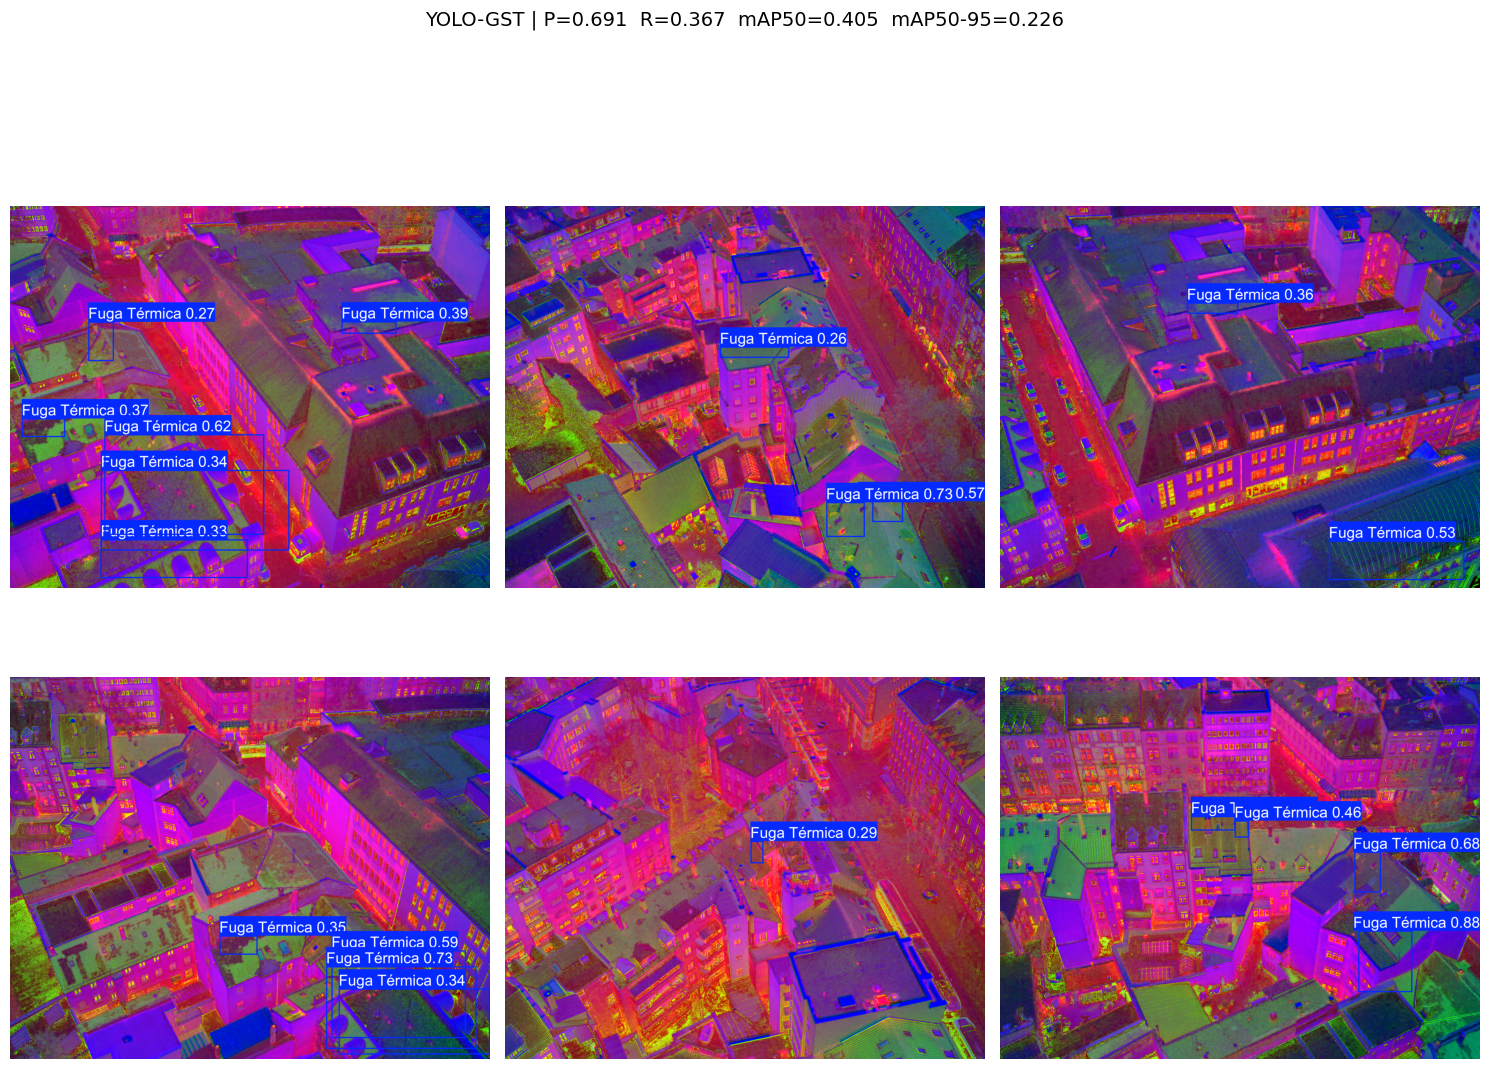

(-0.5, 2399.5, 1199.5, -0.5)

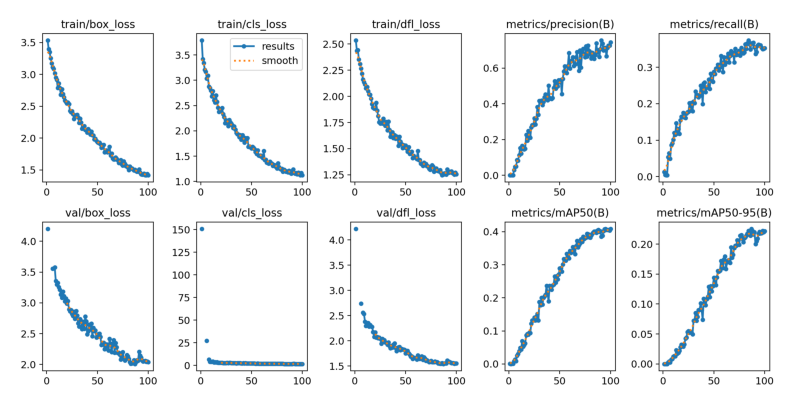

In [3]:


# ========= CONFIG =========
RUN_NAME   = "yolo_gst"  # el mismo 'name=' que usaste en el train
RUNS_DIR   = Path("/home/ignacio/ProyectoFinalVA/runs")
BEST_WEIGHTS = RUNS_DIR / RUN_NAME / "weights" / "best.pt"
IMG_PATH = Path("/home/ignacio/ProyectoFinalVA/runs/yolo_gst/results.png")

DATA_YAML = Path("/home/ignacio/ProyectoFinalVA/YOLO/GST/YOLO_gst.yaml")
DATA_ROOT = Path("/home/ignacio/ProyectoFinalVA/YOLO/GST")
TEST_DIR  = DATA_ROOT / "images" / "test"

N_IMGS = 6
IMGSZ  = 640
CONF   = 0.25

model = YOLO(str(BEST_WEIGHTS))

# --------- 1) Métricas globales en val ---------
metrics = model.val(data=str(DATA_YAML))   # asegura usar tu YAML

mp    = metrics.box.mp
mr    = metrics.box.mr
map50 = metrics.box.map50
map95 = metrics.box.map

print("===== MÉTRICAS GLOBALES (VAL) =====")
print(f"Precision   (mp)      : {mp:.3f}")
print(f"Recall      (mr)      : {mr:.3f}")
print(f"mAP@0.5     (map50)   : {map50:.3f}")
print(f"mAP@0.5:0.95 (map)    : {map95:.3f}")
print("====================================")

# --------- 2) Predicciones sobre algunas imágenes de test ---------
test_paths = sorted(TEST_DIR.glob("*.png"))
if not test_paths:
    raise RuntimeError(f"No encontré PNGs en {TEST_DIR}")

sample = random.sample(test_paths, min(N_IMGS, len(test_paths)))

results = model.predict(
    source=[str(p) for p in sample],
    imgsz=IMGSZ,
    conf=CONF,
    save=False,
    verbose=False
)

cols = 3
rows = (len(results) + cols - 1) // cols
plt.figure(figsize=(5 * cols, 5 * rows + 2))

# Texto con métricas globales (arriba de todo)
plt.suptitle(
    f"YOLO-GST | P={mp:.3f}  R={mr:.3f}  mAP50={map50:.3f}  mAP50-95={map95:.3f}",
    fontsize=14, y=0.98
)

for i, (p, r) in enumerate(zip(sample, results), start=1):
    plotted = r.plot()         # BGR
    plotted = plotted[..., ::-1]  # a RGB
    ax = plt.subplot(rows, cols, i)
    ax.imshow(plotted)
    ax.set_title(
        '', fontsize=9)
    ax.axis("off")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
plt.figure(figsize=(10,6))
plt.imshow(plt.imread(IMG_PATH)); plt.axis("off")

